In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"클릭한 좌표: ({x}, {y})")

# 이미지 경로 설정
image_path = '/Users/wjsong/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/dataset/final_map.jpg'
image = cv2.imread(image_path)

cv2.imshow("test", image)
cv2.setMouseCallback("test", mouse_callback)

cv2.waitKey(0)
cv2.destroyAllWindows()

클릭한 좌표: (1156, 941)
클릭한 좌표: (1512, 904)


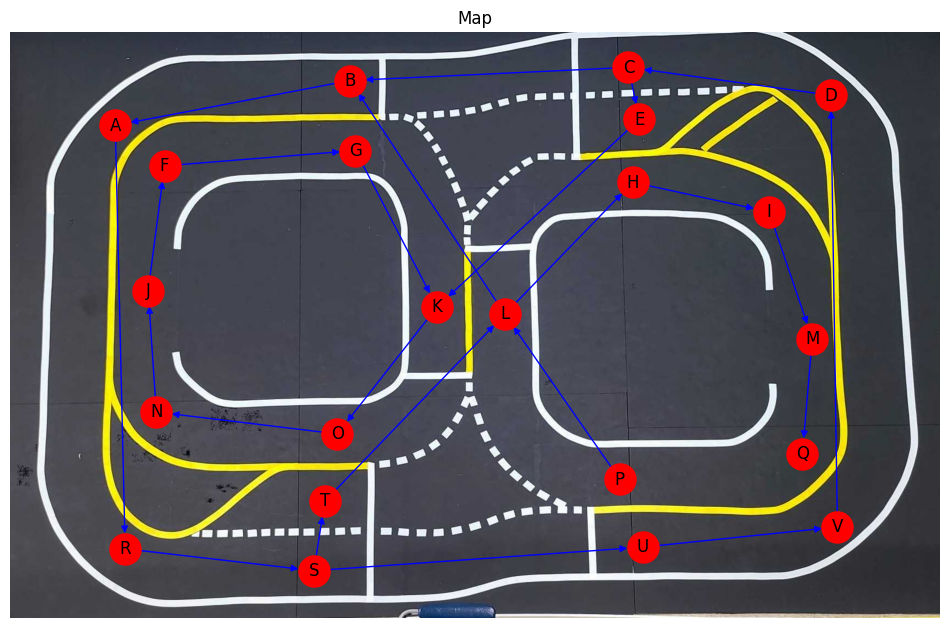

In [5]:
# 1. 원본 맵 이미지 불러오기
img_path = "/Users/wjsong/dev_ws/ros-repo-5/admin/src/ai_server/ai_train/dataset/final_map.jpg" 
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. 그래프 정의
G = nx.DiGraph()
G.add_edges_from([
    ('A', 'R'), ('B', 'A'), ('C', 'B'), ('C', 'E'), ('E', 'K'), ('D', 'C'),
    ('F', 'G'), ('G', 'K'), ('H', 'I'), ('I', 'M'),
    ('J', 'F'), ('K', 'O'), ('L', 'B'), ('L', 'H'), ('M', 'Q'),
    ('N', 'J'), ('O', 'N'), ('P', 'L'), ('P', 'L'),
    ('R', 'S'), ('S', 'T'), ('S', 'U'), ('T', 'L'), ('U', 'V'), ('V', 'D')
])

# 3. 노드 위치 설정 (두 번째 이미지 기준 좌표)
positions = {
    "A": (192, 170), "B": (621, 88), "C": (1130, 64), "D": (1500, 115), "E": (1150, 159),
    "F": (282, 244), "G": (631, 216), "H": (1138, 274), "I": (1387, 328),
    "J": (252, 472), "K": (780, 502), "L": (904, 515), "M": (1466, 560),
    "N": (267, 694), "O": (598, 734), "P": (1114, 817), "Q": (1448, 770),
    "R": (210, 944), "S": (555, 984), "T": (575, 857), "U": (1156, 941), "V": (1512, 904)
}

# 4. 이미지와 그래프 함께 표시
plt.figure(figsize=(12, 8))
plt.imshow(img)
nx.draw(G, pos=positions, with_labels=True, node_color='red', edge_color='blue', node_size=500, font_color='black')
plt.axis('off')
plt.title("Map")
plt.show()

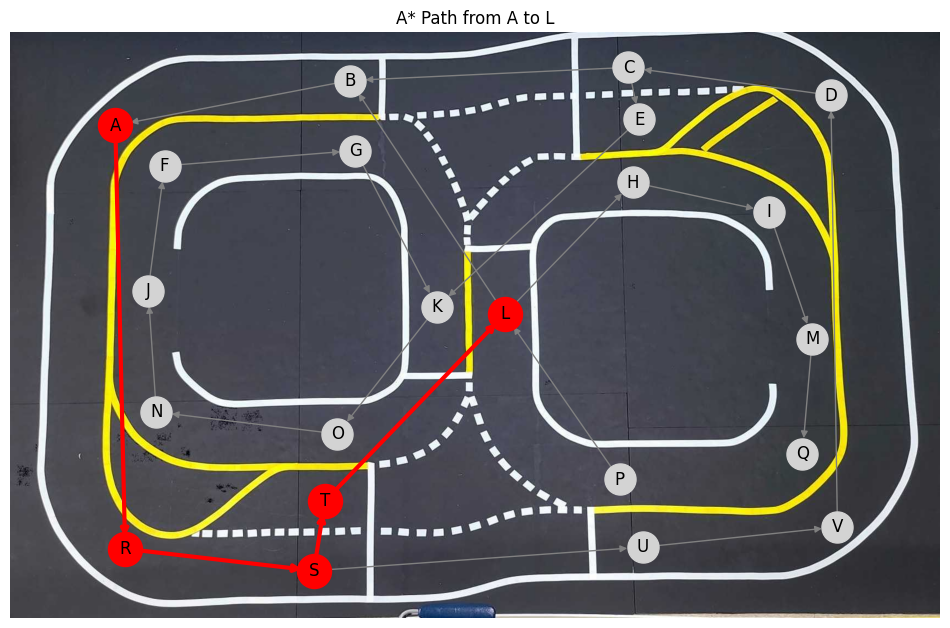

In [7]:
# 4. 휴리스틱 함수 (유클리디안 거리)
def heuristic(n1, n2):
    x1, y1 = positions[n1]
    x2, y2 = positions[n2]
    return np.hypot(x2 - x1, y2 - y1)

# 5. 가중치 추가 (거리 기반)
for u, v in G.edges:
    dist = heuristic(u, v)
    G[u][v]['weight'] = dist

# 6. 출발지와 목적지 설정
start_node = "A"
end_node = "L"

# 7. A* 알고리즘으로 최단 경로 찾기
path = nx.astar_path(G, start_node, end_node, heuristic=heuristic)

# 8. 경로 시각화
plt.figure(figsize=(12, 8))
plt.imshow(img)

# 전체 그래프 표시
nx.draw(G, pos=positions, with_labels=True, node_color='lightgray', edge_color='gray', node_size=500, font_color='black')

# 최단 경로 강조
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_nodes(G, pos=positions, nodelist=path, node_color='red', node_size=600)
nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color='red', width=3)

plt.axis('off')
plt.title(f"A* Path from {start_node} to {end_node}")
plt.show()

In [ ]:
# 그래프 G 및 positions, heuristic 함수는 기존 코드 재사용

def get_next_behavior(path, positions):
    """
    경로 상 현재 방향에 따라 behavior 결정
    """
    behaviors = []
    for i in range(len(path) - 2):
        prev = np.array(positions[path[i]])
        curr = np.array(positions[path[i+1]])
        nxt = np.array(positions[path[i+2]])

        v1 = curr - prev
        v2 = nxt - curr

        angle = np.degrees(np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0]))
        angle = (angle + 360) % 360

        if angle < 45 or angle > 315:
            behavior = "go straight"
        elif 45 <= angle <= 135:
            behavior = "left"
        elif 225 <= angle <= 315:
            behavior = "right"
        else:
            behavior = "rotate"

        behaviors.append((path[i+1], behavior))
    
    # 마지막 지점은 도착
    behaviors.append((path[-1], "arrived"))
    return behaviors


In [10]:
start_node = "A"
goal_node = "L"

if nx.has_path(G, start_node, goal_node):
    path = nx.astar_path(G, start_node, goal_node, heuristic=heuristic)
    print("경로:", path)
    behaviors = get_next_behavior(path, positions)
    for node, action in behaviors:
        print(f"At node {node}: {action}")
else:
    print(f"경로 없음: {start_node} → {goal_node}")

경로: ['A', 'R', 'S', 'T', 'L']
At node R: turn right
At node S: turn right
At node T: go straight
At node L: arrived
